<a href="https://colab.research.google.com/github/todicode/ARIMA-Model/blob/main/ARIMAModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install statsmodels

Như đoạn code của Tuấn Anh, dòng lệnh trên cho thấy thư viện statsmodels đã được cài sẵn trên ggcolab

# Kết nối google colab vào drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Nhớ phải cho gg colab kết nối với drive nha, nó sẽ gửi cái bảng yêu cầu kết nối với drive á, nhớ bấm tick hết mấy cái ô vuông nó gửi là được.


#Thêm các thư viện vào

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


=> Câu lệnh này để liên kết Driver và colab, kết nối tại thư mục "/content/drive"

In [122]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')
from common.utils import load_data, mape

-import sys: gọi module hệ thống sys để làm việc với môi trường Python.

-sys.path.append(...): bổ sung thư mục Google Drive (/content/drive/MyDrive/Colab Notebooks/Báo cáo 3) vào danh sách mà Python sẽ tìm kiếm khi import.

-from common.utils import load_data, mape: nạp trực tiếp các hàm load_data và mape từ file utils.py nằm trong thư mục common trên Google Drive.

#Thêm lại thư viện sau khi fix lỗi

In [ ]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from common.utils import load_data, mape
from IPython.display import Image

%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore") # specify to ignore warning messages

In [ ]:
energy = load_data('./data')[['load']]
energy.head(10)

,load
2012-01-01 00:00:00,"2,698.00"
2012-01-01 01:00:00,"2,558.00"
2012-01-01 02:00:00,"2,444.00"
2012-01-01 03:00:00,"2,402.00"
2012-01-01 04:00:00,"2,403.00"
2012-01-01 05:00:00,"2,453.00"
2012-01-01 06:00:00,"2,560.00"
2012-01-01 07:00:00,"2,719.00"
2012-01-01 08:00:00,"2,916.00"
2012-01-01 09:00:00,"3,105.00"


load_data('./data') => hàm load_data (trong file common/utils.py) đọc dữ liệu từ thư mục ./data.Ở đây, nó đã đọc file energy.csv trong thư mục data.

[['load']] => chọn đúng cột load nhưng giữ kết quả ở dạng DataFrame trong file dữ liệu (vì trong file gốc có nhiều cột hơn).

Gán vào biến energy => lúc này energy chỉ chứa cột tải điện (load).

energy.head(10) => hiển thị 10 dòng đầu tiên của dữ liệu để kiểm tra nhanh.

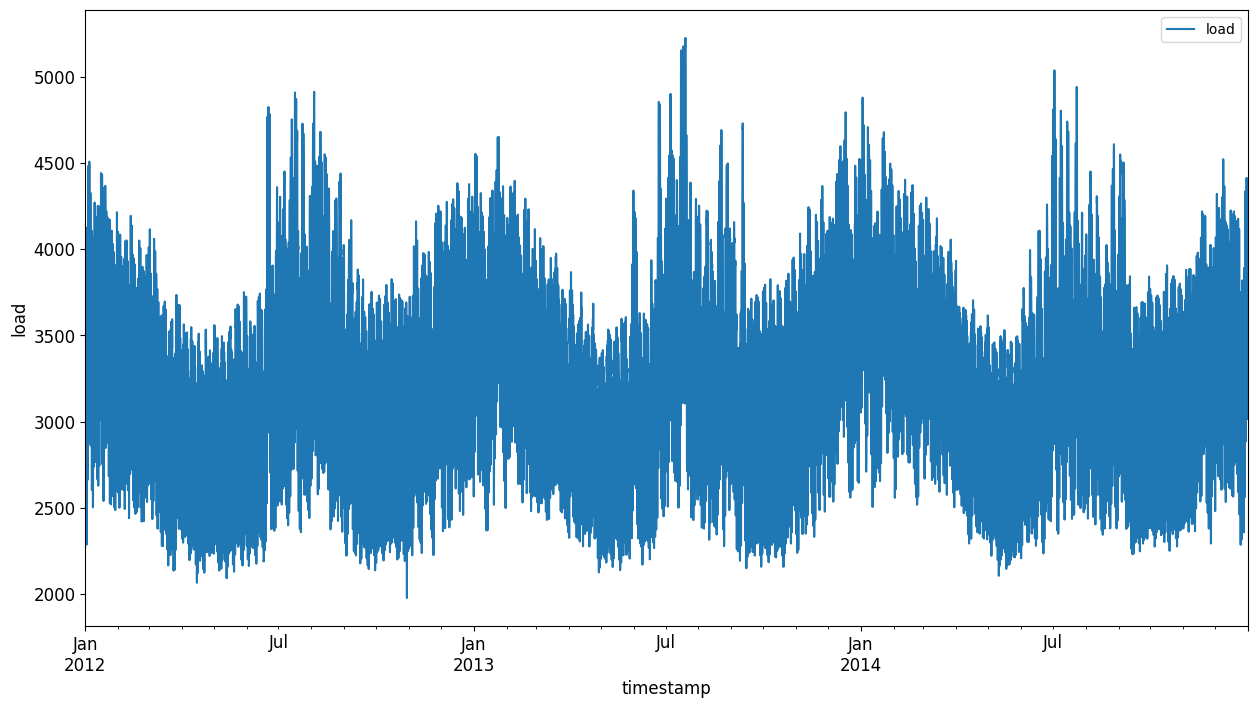

In [ ]:
energy.plot(y='load', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

=> Lệnh này để vẽ biểu đồ cho biến energy. Cụ thể lệnh này thì tụi em chưa học đến.

# Tạo training và testing dataset

Bắt đầu tạo chia dataset thành 2 bộ data như thầy đã nói.

In [ ]:
train_start_dt = '2014-11-01 00:00:00'
test_start_dt = '2014-12-30 00:00:00'

Lệnh này để gán biến, theo tụi em nghĩ là họ chia dataset thành 2 bộ.

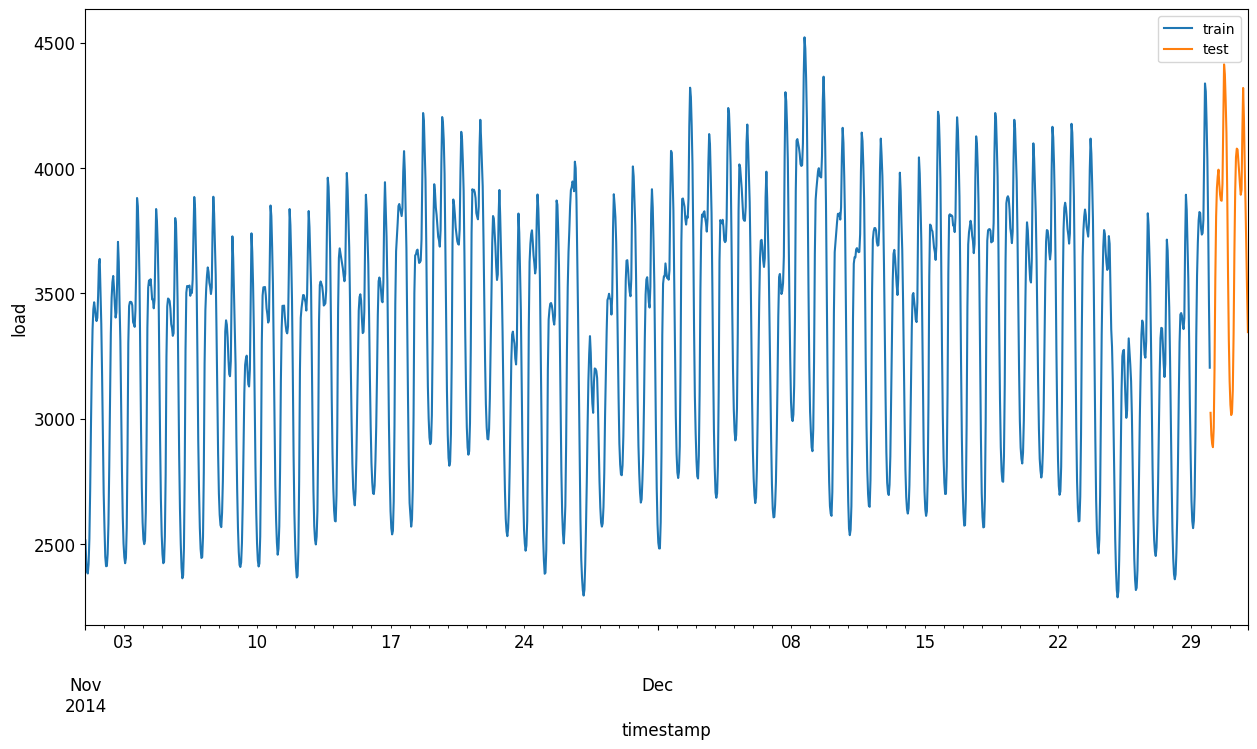

In [121]:
energy[(energy.index < test_start_dt) & (energy.index >= train_start_dt)][['load']].rename(columns={'load':'train'}) \
    .join(energy[test_start_dt:][['load']].rename(columns={'load':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

=> Đoạn lệnh này lại dùng để vẽ biểu đồ.

In [ ]:
train = energy.copy()[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['load']]
test = energy.copy()[energy.index >= test_start_dt][['load']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (1416, 1)
Test data shape:  (48, 1)


train = energy.copy(): Tạo bản sao cho energy để tránh ảnh hưởng dữ liệu ban đầu.
[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['load']]: chọn các dòng có thời gian nằm trong khoảng từ train_start_dt đến trước test_start_dt.
[['load']]: Chỉ giữ lại cột "load".
Dòng 1 để chọn tập train.
print(train.shape): in ra số hàng và cột của tập train => Bước này để kiểm tra xem tách đúng chưa.
Tập test cũng tương tự.

In [ ]:
scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)
train.head(10)

,load
2014-11-01 00:00:00,0.10
2014-11-01 01:00:00,0.07
2014-11-01 02:00:00,0.05
2014-11-01 03:00:00,0.04
2014-11-01 04:00:00,0.06
2014-11-01 05:00:00,0.10
2014-11-01 06:00:00,0.19
2014-11-01 07:00:00,0.31
2014-11-01 08:00:00,0.40
2014-11-01 09:00:00,0.48


=> Điều chỉnh dữ liệu theo phạm vi (0, 1)

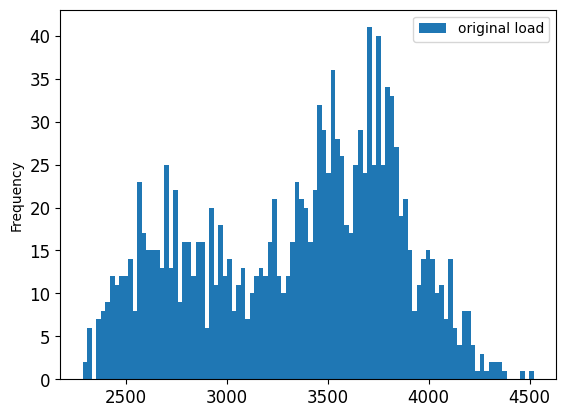

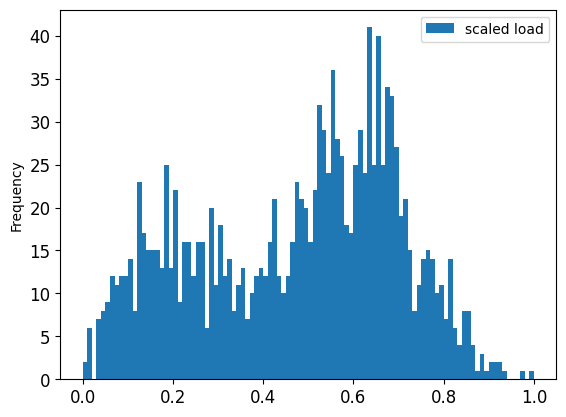

In [ ]:
energy[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['load']].rename(columns={'load':'original load'}).plot.hist(bins=100, fontsize=12)
train.rename(columns={'load':'scaled load'}).plot.hist(bins=100, fontsize=12)
plt.show()

Đoạn mã này để vẽ biểu đồ cho dữ liệu gốc trước và sau khi train => Hình dung dữ liệu gốc so với dữ liệu đã thu nhỏ. Ở đây biến x đã được thu nhỏ lại

In [ ]:
test['load'] = scaler.transform(test)
test.head()

,load
2014-12-30 00:00:00,0.33
2014-12-30 01:00:00,0.29
2014-12-30 02:00:00,0.27
2014-12-30 03:00:00,0.27
2014-12-30 04:00:00,0.30


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

- Bây giờ bạn đã hiệu chỉnh dữ liệu đã chia tỷ lệ, bạn có thể chia tỷ lệ dữ liệu thử nghiệm. (Đoạn này tụi em chưa hiểu họ nói gì lắm).

In [ ]:
#test horizon = 3 by GIABAO
# Specify the number of steps to forecast ahead
HORIZON = 3
print('Forecasting horizon:', HORIZON, 'hours')

Forecasting horizon: 3 hours


In [ ]:
order = (4, 1, 0)
seasonal_order = (1, 1, 0, 24)

model = SARIMAX(endog=train, order=order, seasonal_order=seasonal_order)
results = model.fit()

print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               load   No. Observations:                 1416
Model:             SARIMAX(4, 1, 0)x(1, 1, 0, 24)   Log Likelihood                3477.240
Date:                            Mon, 20 Oct 2025   AIC                          -6942.479
Time:                                    14:01:24   BIC                          -6911.052
Sample:                                11-01-2014   HQIC                         -6930.727
                                     - 12-29-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8413      0.016     52.209      0.000       0.810       0.873
ar.L2         -0.5222      0.034   

In [ ]:
#test_shifted by GIABAO
test_shifted = test.copy()

for t in range(1, HORIZON):
    test_shifted['load+'+str(t)] = test_shifted['load'].shift(-t, freq='H')

test_shifted = test_shifted.dropna(how='any')
test_shifted.head(5)

,load,load+1,load+2
2014-12-30 00:00:00,0.33,0.29,0.27
2014-12-30 01:00:00,0.29,0.27,0.27
2014-12-30 02:00:00,0.27,0.27,0.30
2014-12-30 03:00:00,0.27,0.30,0.41
2014-12-30 04:00:00,0.30,0.41,0.57


In [ ]:
%%time
training_window = 720 # dedicate 30 days (720 hours) for training

train_ts = train['load']
test_ts = test_shifted

history = [x for x in train_ts]
history = history[(-training_window):]

predictions = list()

order = (2, 1, 0)
seasonal_order = (1, 1, 0, 24)

for t in range(test_ts.shape[0]):
    model = SARIMAX(endog=history, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    yhat = model_fit.forecast(steps = HORIZON)
    predictions.append(yhat)
    obs = list(test_ts.iloc[t])
    # move the training window
    history.append(obs[0])
    history.pop(0)
    print(test_ts.index[t])
    print(t+1, ': predicted =', yhat, 'expected =', obs)

2014-12-30 00:00:00
1 : predicted = [0.32 0.29 0.28] expected = [0.32945389435989236, 0.2900626678603402, 0.2739480752014323]
2014-12-30 01:00:00
2 : predicted = [0.3  0.29 0.3 ] expected = [0.2900626678603402, 0.2739480752014323, 0.26812891674127126]
2014-12-30 02:00:00
3 : predicted = [0.27 0.28 0.32] expected = [0.2739480752014323, 0.26812891674127126, 0.3025962399283795]
2014-12-30 03:00:00
4 : predicted = [0.28 0.32 0.42] expected = [0.26812891674127126, 0.3025962399283795, 0.40823634735899716]
2014-12-30 04:00:00
5 : predicted = [0.3  0.39 0.54] expected = [0.3025962399283795, 0.40823634735899716, 0.5689346463742166]
2014-12-30 05:00:00
6 : predicted = [0.4  0.55 0.66] expected = [0.40823634735899716, 0.5689346463742166, 0.6799462846911368]
2014-12-30 06:00:00
7 : predicted = [0.57 0.68 0.75] expected = [0.5689346463742166, 0.6799462846911368, 0.7309758281110115]
2014-12-30 07:00:00
8 : predicted = [0.68 0.75 0.8 ] expected = [0.6799462846911368, 0.7309758281110115, 0.75111906893

In [ ]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test.index[0:len(test.index)-HORIZON+1]
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.array(np.transpose(test_ts)).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

,timestamp,h,prediction,actual
0,2014-12-30 00:00:00,t+1,"3,008.78","3,023.00"
1,2014-12-30 01:00:00,t+1,"2,955.62","2,935.00"
2,2014-12-30 02:00:00,t+1,"2,900.21","2,899.00"
3,2014-12-30 03:00:00,t+1,"2,917.56","2,886.00"
4,2014-12-30 04:00:00,t+1,"2,946.62","2,963.00"


#Kiểm tra sự chính xác của mô hình

In [ ]:
if(HORIZON > 1):
    eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
    print(eval_df.groupby('h')['APE'].mean())

h
t+1   0.01
t+2   0.01
t+3   0.02
Name: APE, dtype: float64


In [ ]:
print('One step forecast MAPE: ', (mape(eval_df[eval_df['h'] == 't+1']['prediction'], eval_df[eval_df['h'] == 't+1']['actual']))*100, '%')

One step forecast MAPE:  0.5585638555215716 %


In [ ]:
print('Multi-step forecast MAPE: ', mape(eval_df['prediction'], eval_df['actual'])*100, '%')

Multi-step forecast MAPE:  1.1489114413632218 %


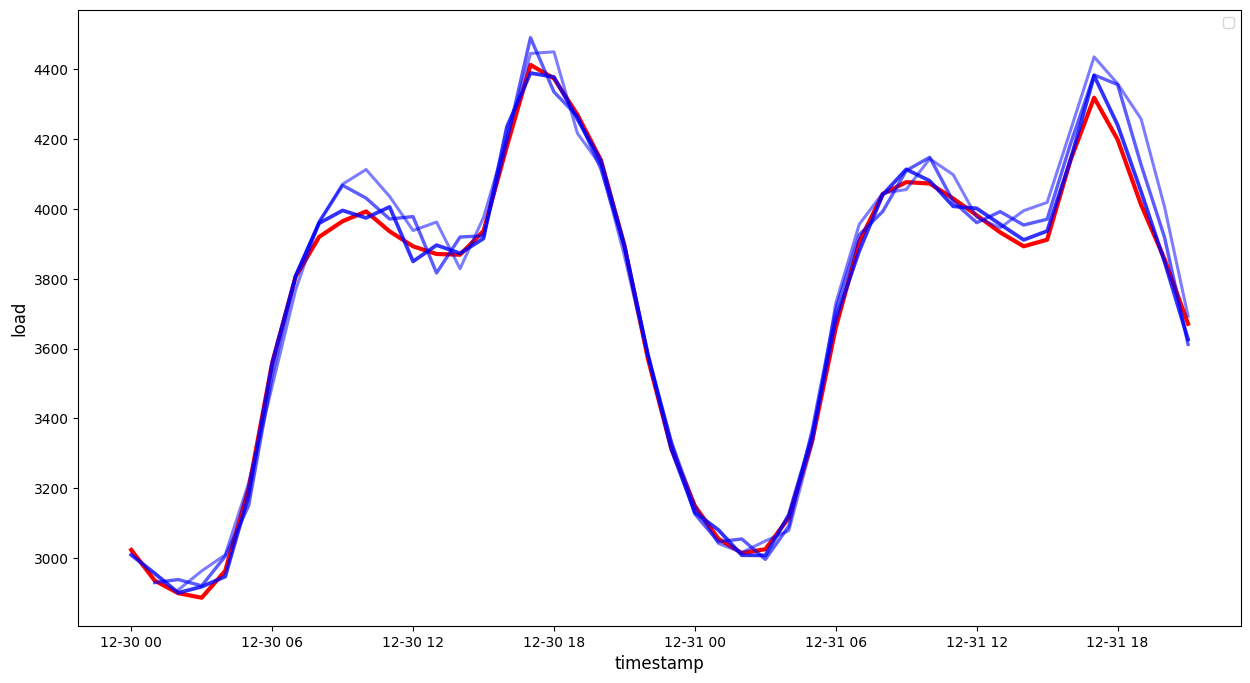

In [ ]:
if(HORIZON == 1):
    # Single-step forecast
    eval_df.plot(x='timestamp', y=['actual', 'prediction'], style=['r', 'b'], figsize=(15, 8))
else:
    # Multi-step forecast
    plot_df = eval_df[eval_df.h == 't+1'][['timestamp', 'actual']].copy()

    # Gộp tất cả các dự đoán t+1, t+2, t+3,...
    for t in range(1, HORIZON + 1):
        plot_df['t+' + str(t)] = eval_df[eval_df.h == 't+' + str(t)]['prediction'].values

    fig, ax = plt.subplots(figsize=(15, 8))

    # Vẽ đường thực tế màu đỏ
    ax.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=3)

    # Vẽ các đường dự đoán màu xanh, giảm độ đậm dần theo bước dự báo
    for t in range(1, HORIZON + 1):
        x = plot_df['timestamp'][(t - 1):]
        y = plot_df['t+' + str(t)][0:len(x)]
        ax.plot(x, y,
                color='blue',
                linewidth=3 * math.pow(0.9, t),
                alpha=math.pow(0.8, t))


    ax.legend(loc='best')
    ax.set_xlabel('timestamp', fontsize=12)
    ax.set_ylabel('load', fontsize=12)


plt.show()
